In [1]:
# How far back does the 'Max past mass' occur?

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/e/jb2854/Mergers_Project')
from illustris_python import illustris_python as il
sys.path.append('/u/e/jb2854/Mergers_Project')
import tools

basePath = '/x/Physics/AstroPhysics/Shared-New/DATA/IllustrisTNG/TNG100-1/output'

In [2]:
def mergerInfo(tree, minMassRatio=1e-10, massPartType='stars', index=0):
    """ Based off numMergers function to identify the mergers, this function returns the two progenitor masses (default stellar) and the snapshot in which merging occured"""
    # verify the input sub-tree has the required fields
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType','SnapNum', 'DescendantID']

    if not set(reqFields).issubset(tree.keys()):
        raise Exception('Error: Input tree needs to have loaded fields: '+', '.join(reqFields))

    numMergers   = 0
    mergerProgenitors = []
    invMassRatio = 1.0 / minMassRatio

    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    fpID   = tree['FirstProgenitorID'][index]

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        fpMassMax  = il.sublink.maxPastMassSnapNum(tree, fpIndex, massPartType)
        fpMass = fpMassMax[0]
        fpMassMaxSnap = fpMassMax[1]
        #fpMass  = il.sublink.maxPastMass(tree, fpIndex, massPartType)
        

        # explore breadth
        npID = tree['NextProgenitorID'][fpIndex]

        while npID != -1:
            npIndex = index + (npID - rootID)
            npMassMax  = il.sublink.maxPastMassSnapNum(tree, npIndex, massPartType)
            npMass = npMassMax[0]
            npMassMaxSnap = npMassMax[1]
            #npMass  = il.sublink.maxPastMass(tree, npIndex, massPartType)

            # count if both masses are non-zero, and ratio exceeds threshold
            if fpMass > 1e-6 and npMass > 1e-6:
                ratio = npMass / fpMass

                if ratio >= minMassRatio and ratio <= invMassRatio:
                    numMergers += 1
                    #mergerProgenitors.append([tree['SnapNum'][fpIndex] - fpMassMaxSnap, tree['SubfindID'][fpIndex], tree['SnapNum'][fpIndex], tree['SubhaloMass'][fpIndex]])
                    #mergerProgenitors.append([tree['SnapNum'][npIndex] - npMassMaxSnap, tree['SubfindID'][npIndex], tree['SnapNum'][npIndex], tree['SubhaloMass'][npIndex]])
                    mergerProgenitors.append([tree['SnapNum'][npIndex] - npMassMaxSnap, npMass, tree['SubhaloMassType'][npIndex, il.util.partTypeNum('stars')], 1])
                    #mergerProgenitors.append([tree['SubfindID'][fpIndex], tree['SnapNum'][fpIndex], tree['SubhaloMass'][fpIndex]])
            npID = tree['NextProgenitorID'][npIndex]

        fpID = tree['FirstProgenitorID'][fpIndex]
        mergerProgenitors.append([tree['SnapNum'][fpIndex] - fpMassMaxSnap, fpMass, tree['SubhaloMassType'][fpIndex, il.util.partTypeNum('stars')], 0])

    return mergerProgenitors

In [3]:
fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType','SnapNum', 'DescendantID', 'SubfindID']
groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])

subhalo_flag = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloFlag'])
good_cen_idx = np.intersect1d(groupFirstSub, np.where(subhalo_flag==1)[0])
SnapDifferences = []
ratio = 1/10

In [4]:
SnapDifferences = np.zeros([0,4])
for i in range(0, 1000, 1):
    tree = il.sublink.loadTree(basePath,99,good_cen_idx[i],fields=fields)
    SnapDifferences = np.vstack((SnapDifferences, mergerInfo(tree, ratio)))

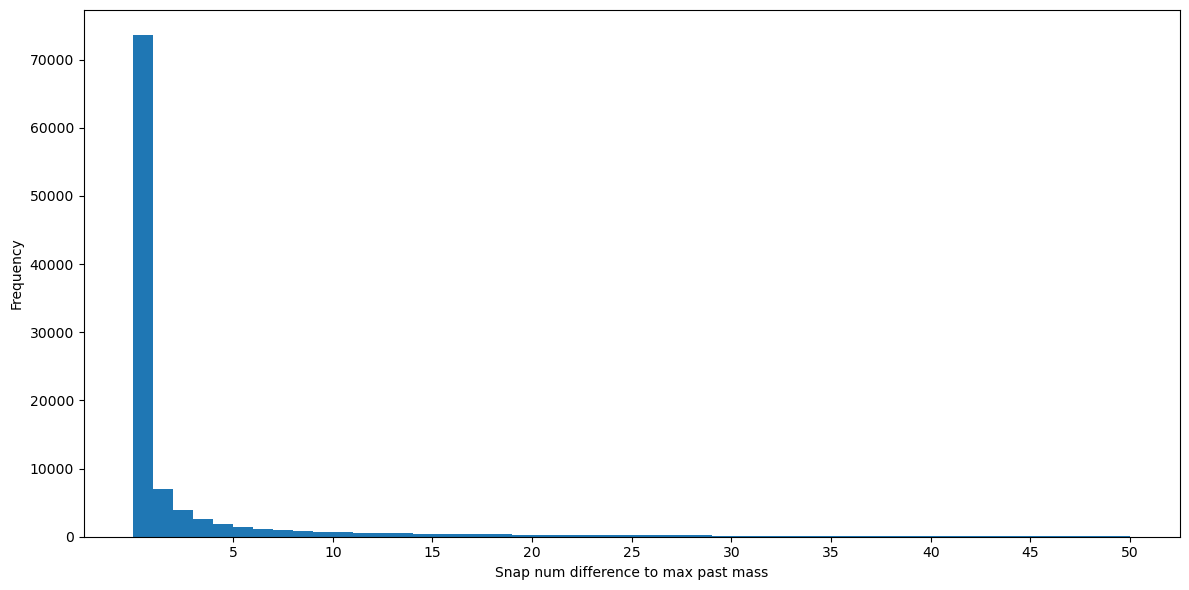

In [82]:
# Allowing all stellar masses of subhalos in the analysis
plt.figure(figsize = (12,6))
plt.hist(SnapDifferences, bins = np.linspace(0,50,51))
plt.xlabel('Snap num difference to max past mass')
plt.ylabel('Frequency')
plt.xticks(np.linspace(5, 50, 10))
plt.tight_layout()

In [57]:
groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])
subhalo_flag = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloFlag'])
good_cen_idx = np.intersect1d(groupFirstSub, np.where(subhalo_flag==1)[0])

SnapDifferences = []
for i in range(0, 1000, 1):
    tree = il.sublink.loadTree(basePath,99,good_cen_idx[i],fields=fields)
    SnapDifferences = SnapDifferences + mergerInfo(tree, ratio)

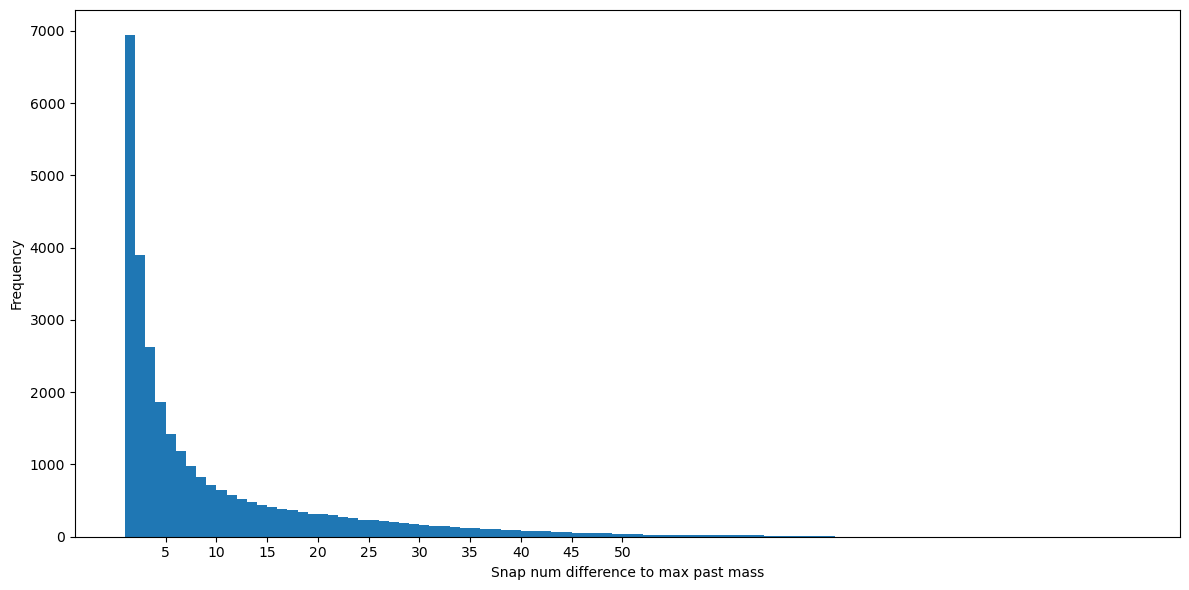

In [62]:
# Limiting masses to the min. mass of a 'good' central galaxy at z = 0
plt.figure(figsize = (12,6))
plt.hist(SnapDifferences, bins = np.linspace(1,100,100))
plt.xlabel('Snap num difference to max past mass')
plt.ylabel('Frequency')
plt.xticks(np.linspace(5, 50, 10))
plt.tight_layout()

In [87]:
fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType','SubhaloMass', 'SnapNum', 'DescendantID', 'SubfindID']
SnapDifferencesIDs = np.zeros([0,4])
for i in range(0, 100, 1):
    tree = il.sublink.loadTree(basePath,99,good_cen_idx[i],fields=fields)
    SnapDifferencesIDs = np.vstack((SnapDifferencesIDs, mergerInfo(tree, ratio)))

In [17]:
SnapDifferencesIDs = np.array(SnapDifferencesIDs)

In [28]:
SnapDifferencesIDs = SnapDifferencesIDs[SnapDifferencesIDs[:, 0].argsort()]

In [117]:
def mergerInfoMain(tree, minMassRatio=1e-10, massPartType='stars', index=0):
    """ Based off numMergers function to identify the mergers, this function returns the two progenitor masses (default stellar) and the snapshot in which merging occured"""
    # verify the input sub-tree has the required fields
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType','SnapNum', 'DescendantID']

    if not set(reqFields).issubset(tree.keys()):
        raise Exception('Error: Input tree needs to have loaded fields: '+', '.join(reqFields))

    numMergers   = 0
    mergerProgenitors = []
    invMassRatio = 1.0 / minMassRatio

    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    print(index)
    fpID   = tree['FirstProgenitorID'][index]

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        #fpMassMax  = il.sublink.maxPastMassSnapNum(tree, fpIndex, massPartType)
        #fpMass = fpMassMax[0]
        #fpMassMaxSnap = fpMassMax[1]
        fpMass  = il.sublink.maxPastMass(tree, fpIndex, massPartType)
        

        # explore breadth
        npID = tree['NextProgenitorID'][fpIndex]
        
        if npID != -1:
            npIndex = index + (npID - rootID)
            npMass  = il.sublink.maxPastMass(tree, npIndex, massPartType)

            # count if both masses are non-zero, and ratio exceeds threshold
            if fpMass > 1e-6 and npMass > 1e-6:
                ratio = npMass / fpMass

                if ratio >= minMassRatio and ratio <= invMassRatio:
                    numMergers += 1
                    #mergerProgenitors.append([tree['SubfindID'][fpIndex], tree['SnapNum'][fpIndex], tree['SubhaloMass'][fpIndex]])
                    mergerProgenitors.append([tree['SubfindID'][fpIndex], tree['SnapNum'][fpIndex],tree['SubhaloMass'][fpIndex], tree['SubhaloMassType'][fpIndex,il.util.partTypeNum('stars')],
                                             tree['SubhaloMassType'][fpIndex,il.util.partTypeNum('dm')], tree['SubhaloMassType'][fpIndex,il.util.partTypeNum('gas')]])

        fpID = tree['FirstProgenitorID'][fpIndex]

    return mergerProgenitors

97
0


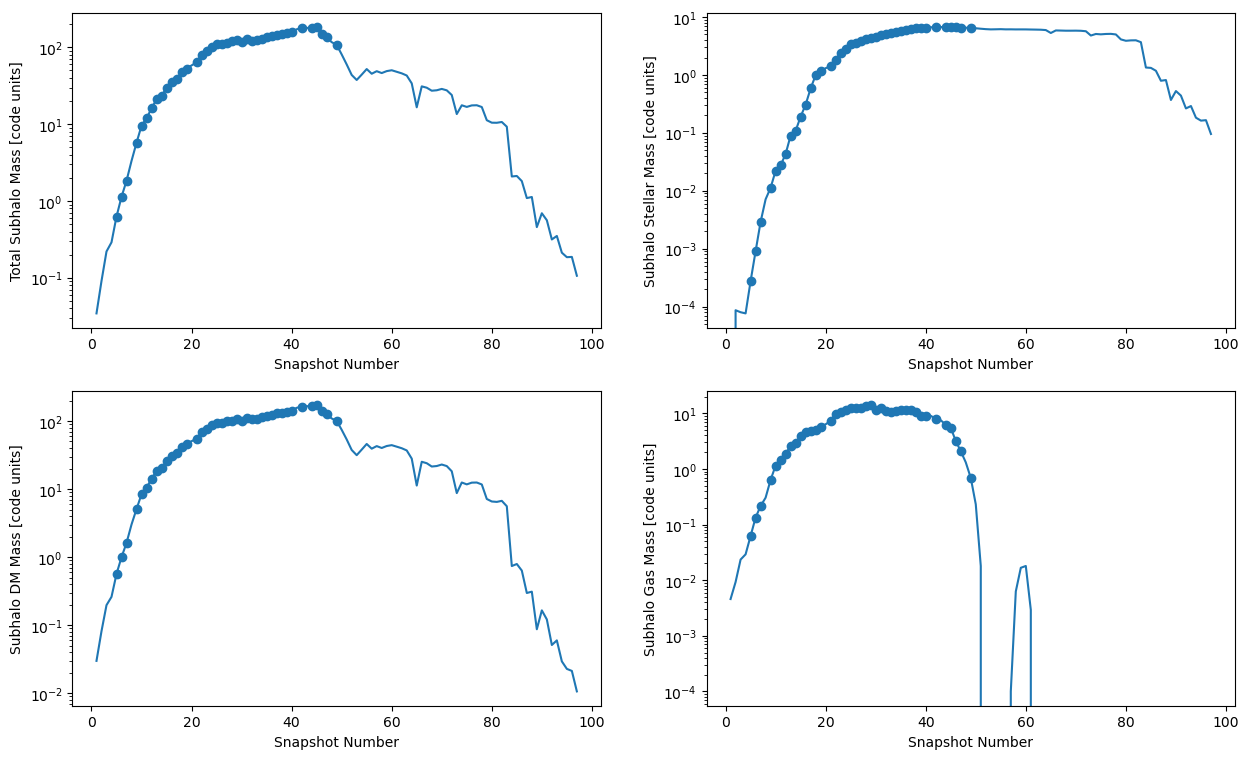

In [121]:
# Plot of the halo that had the most distant max past mass, as total subhalo mass
treeplot = il.sublink.loadTree(basePath,97,120516,fields=fields,onlyMPB=True)
#print(treeplot)
mergers = np.zeros([0,6])

figure = plt.figure(figsize = (15,9))
ax = figure.subplots(nrows = 2, ncols = 2)
ax[0,0].plot(treeplot['SnapNum'],treeplot['SubhaloMass'],'-')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Snapshot Number')
ax[0,0].set_ylabel('Total Subhalo Mass [code units]')

ax[0,1].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('stars')],'-')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('Snapshot Number')
ax[0,1].set_ylabel('Subhalo Stellar Mass [code units]')

ax[1,0].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('dm')],'-')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('Snapshot Number')
ax[1,0].set_ylabel('Subhalo DM Mass [code units]')

ax[1,1].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('gas')],'-')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Snapshot Number')
ax[1,1].set_ylabel('Subhalo Gas Mass [code units]')

print(len(treeplot['SubhaloMassType'][:, il.util.partTypeNum('gas')]))

treeplot = il.sublink.loadTree(basePath,97,120516,fields=fields)
mergers = np.vstack((mergers, np.array(mergerInfoMain(treeplot))))
ax[0,0].scatter(mergers[:,1], mergers[:,2])
ax[0,1].scatter(mergers[:,1], mergers[:,3])
ax[1,0].scatter(mergers[:,1], mergers[:,4])
ax[1,1].scatter(mergers[:,1], mergers[:,5])


48
0


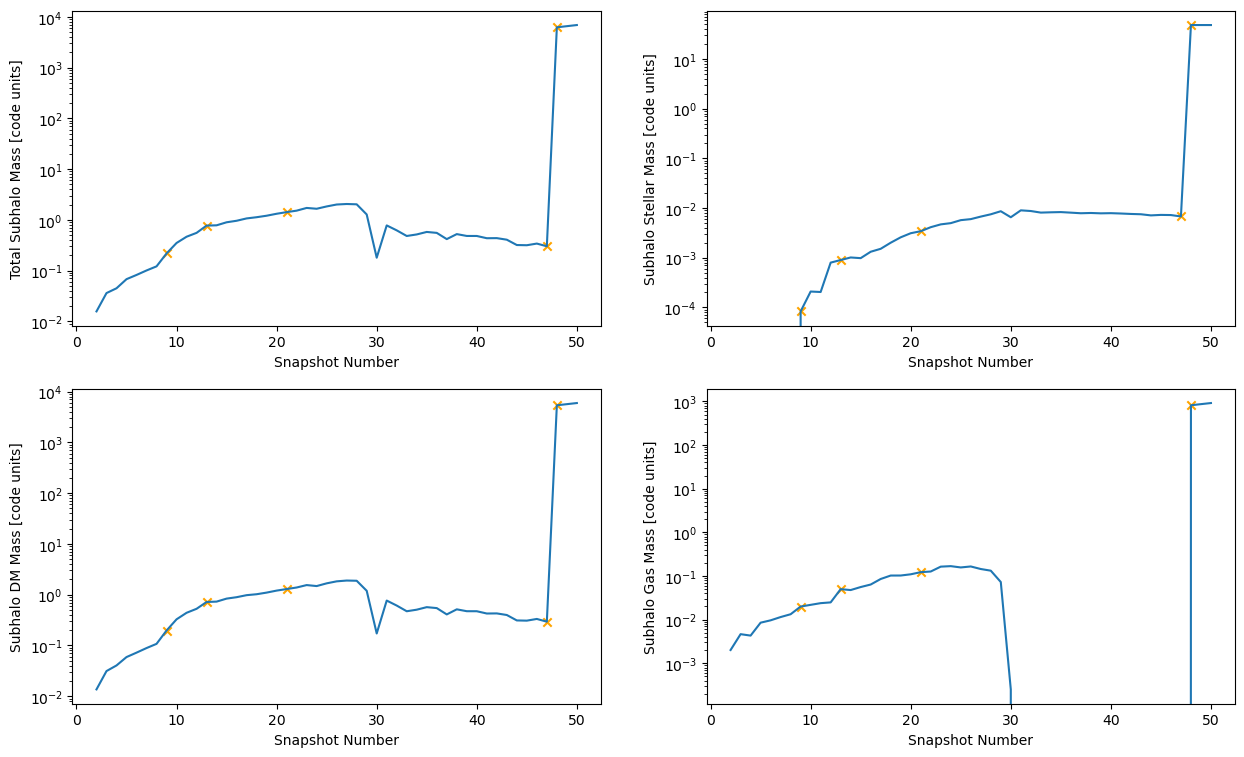

In [127]:
# Plot of the halo that had the most distant max past mass, as total subhalo mass
treeplot = il.sublink.loadTree(basePath,50,0,fields=fields,onlyMPB=True)
#print(treeplot)
mergers = np.zeros([0,6])

figure = plt.figure(figsize = (15,9))
ax = figure.subplots(nrows = 2, ncols = 2)
ax[0,0].plot(treeplot['SnapNum'],treeplot['SubhaloMass'],'-')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Snapshot Number')
ax[0,0].set_ylabel('Total Subhalo Mass [code units]')

ax[0,1].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('stars')],'-')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('Snapshot Number')
ax[0,1].set_ylabel('Subhalo Stellar Mass [code units]')

ax[1,0].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('dm')],'-')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('Snapshot Number')
ax[1,0].set_ylabel('Subhalo DM Mass [code units]')

ax[1,1].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('gas')],'-')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Snapshot Number')
ax[1,1].set_ylabel('Subhalo Gas Mass [code units]')

print(len(treeplot['SubhaloMassType'][:, il.util.partTypeNum('gas')]))

treeplot = il.sublink.loadTree(basePath,50,0,fields=fields)
mergers = np.vstack((mergers, np.array(mergerInfoMain(treeplot))))
ax[0,0].scatter(mergers[:,1], mergers[:,2], marker = 'x', color = 'orange')
ax[0,1].scatter(mergers[:,1], mergers[:,3], marker = 'x', color = 'orange')
ax[1,0].scatter(mergers[:,1], mergers[:,4], marker = 'x', color = 'orange')
ax[1,1].scatter(mergers[:,1], mergers[:,5], marker = 'x', color = 'orange')

In [41]:
SnapDifferencesIDs

array([[0.00000000e+00, 1.30570000e+04, 8.50000000e+01, 1.86242871e+04],
       [1.50000000e+01, 1.31400000e+04, 8.50000000e+01, 2.06529045e+00],
       [0.00000000e+00, 0.00000000e+00, 6.20000000e+01, 1.26131885e+04],
       ...,
       [0.00000000e+00, 6.75000000e+02, 3.00000000e+00, 2.35163093e-01],
       [0.00000000e+00, 6.74000000e+02, 3.00000000e+00, 1.10138750e+00],
       [0.00000000e+00, 6.77000000e+02, 3.00000000e+00, 4.59701829e-02]])

48
0
[[0.00000000e+00 4.80000000e+01 6.23848535e+03]
 [3.05000000e+02 4.70000000e+01 3.01031440e-01]
 [3.21005000e+05 2.10000000e+01 1.41854846e+00]
 [1.59124000e+05 1.30000000e+01 7.69729912e-01]
 [1.00197000e+05 9.00000000e+00 2.17203781e-01]]


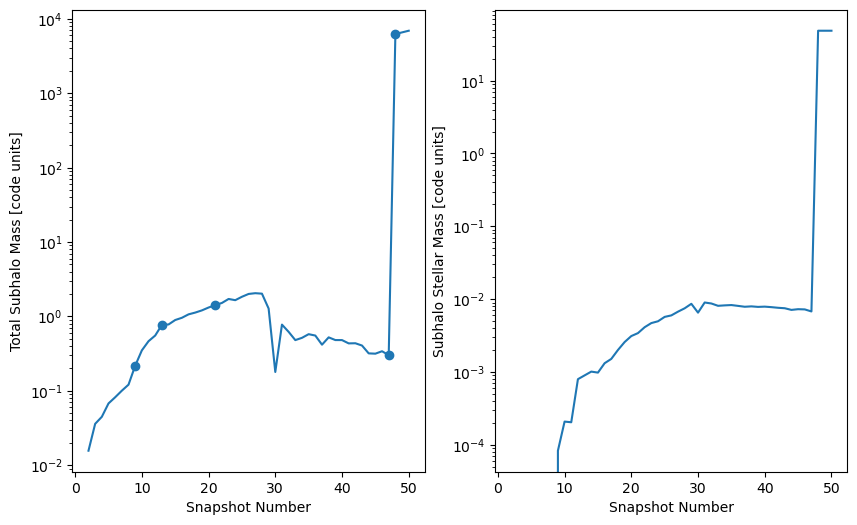

In [98]:
# Plot of the halo that had the most distant max past mass, as total subhalo mass
treeplot = il.sublink.loadTree(basePath,50,0,fields=fields,onlyMPB=True)
#print(treeplot)
mergers = np.zeros([0,6])

figure = plt.figure(figsize = (10,6))
ax = figure.subplots(nrows = 1, ncols = 2)
ax[0].plot(treeplot['SnapNum'],treeplot['SubhaloMass'],'-')
ax[0].set_yscale('log')
ax[0].set_xlabel('Snapshot Number')
ax[0].set_ylabel('Total Subhalo Mass [code units]')

ax[1].plot(treeplot['SnapNum'],treeplot['SubhaloMassType'][:, il.util.partTypeNum('stars')],'-')
ax[1].set_yscale('log')
ax[1].set_xlabel('Snapshot Number')
ax[1].set_ylabel('Subhalo Stellar Mass [code units]')
print(len(treeplot['SubhaloMassType'][:, il.util.partTypeNum('gas')]))

treeplot = il.sublink.loadTree(basePath,50,0,fields=fields)
mergers = np.vstack((mergers, np.array(mergerInfoMain(treeplot))))
ax[0].scatter(mergers[:,1], mergers[:,2])

print(mergers)

In [45]:
SnapDifferencesIDs[13]

array([2.00000000e+00, 0.00000000e+00, 5.00000000e+01, 6.91584961e+03])

In [99]:
treeplot = il.sublink.loadTree(basePath,50,0,fields=fields)

In [100]:
mergerInfoMain(treeplot)

0


[[0, 48, 6238.4854],
 [305, 47, 0.30103144],
 [321005, 21, 1.4185485],
 [159124, 13, 0.7697299],
 [100197, 9, 0.21720378]]

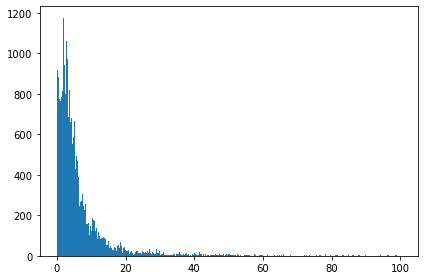

In [32]:
plt.hist(SnapDifferences[:,1], np.linspace(0,100,1001))
plt.tight_layout()

In [51]:
nonzero = np.zeros([0,3])
for i in range(len(SnapDifferences)):
    if SnapDifferences[i, 1] -  SnapDifferences[i, 2] != 0:
        nonzero = np.vstack((nonzero, SnapDifferences[i, :]))

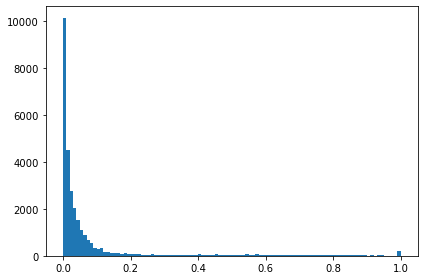

In [63]:
plt.hist((nonzero[:,1] - nonzero[:,2])/nonzero[:,1], np.linspace(0,1,101))
plt.tight_layout()

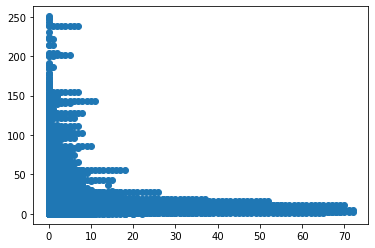

In [58]:
plt.scatter(SnapDifferences[:,0], SnapDifferences[:,1])

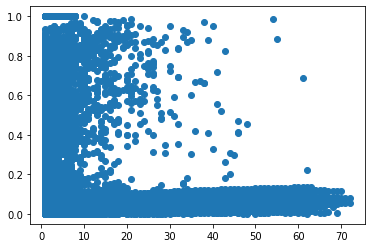

In [57]:
plt.scatter(nonzero[:,0], (nonzero[:,1] - nonzero[:,2])/nonzero[:,1])

In [6]:
def percentages(SnapDifferences):
    percentages = np.zeros([0,1])
    for i in range(len(SnapDifferences)):
        if SnapDifferences[i, 1] -  SnapDifferences[i, 2] != 0:
            percentages = np.vstack((percentages, (SnapDifferences[i,1] - SnapDifferences[i,2])/SnapDifferences[i,1]))
        else:
            percentages = np.vstack((percentages, (SnapDifferences[i,1] - SnapDifferences[i,2])/SnapDifferences[i,1]))
    return percentages
        

In [7]:
firstprogs = nextprogs = np.zeros([0,4])
for i in range(len(SnapDifferences)):
    if SnapDifferences[i, 3] == 0:
        firstprogs = np.vstack((firstprogs, SnapDifferences[i,:]))
    else:
        nextprogs = np.vstack((nextprogs, SnapDifferences[i,:]))
firstprog_perc = percentages(firstprogs)

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

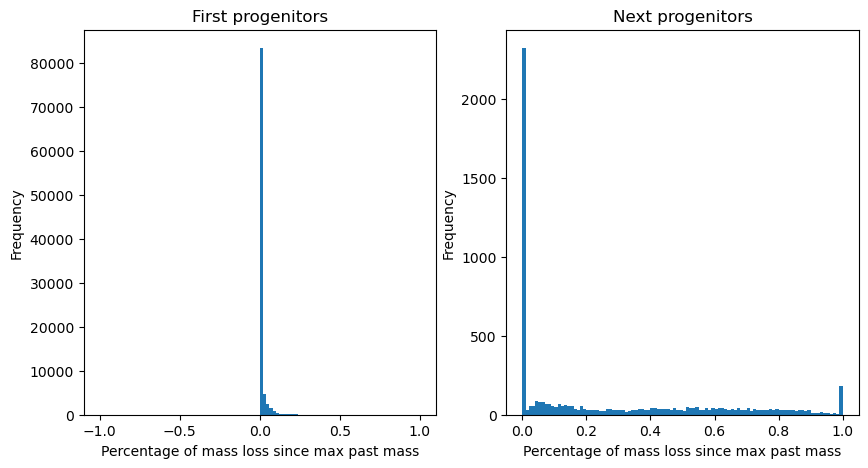

In [12]:
fig = plt.figure(figsize = (10,5))
ax = fig.subplots(1,2)

ax[0].hist(percentages(firstprogs), np.linspace(-1,1,101))
ax[1].hist(percentages(nextprogs), np.linspace(0,1,101))
ax[0].set_title('First progenitors')
ax[1].set_title('Next progenitors')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].set_xlabel('Percentage of mass loss since max past mass')
ax[1].set_xlabel('Percentage of mass loss since max past mass')
#plt.hist(percentages(firstprogs), np.linspace(0,1,101))
#plt.hist(percentages(nextprogs), np.linspace(0,1,101))
plt.tight_layout

# What are the galaxies that lose no mass - small mass? small mass ratio? - Why less next progenitors

In [78]:

count = 0
for i in range (len(firstprogs)):
    if firstprogs[i,2] == 0:
        count += 1
print(count)
firstprogs = firstprogs[firstprogs[:,2] != 0]
nextprogs = nextprogs[nextprogs[:,2] != 0]
nextprogs = nextprogs[nextprogs[:,1] != 0]


0


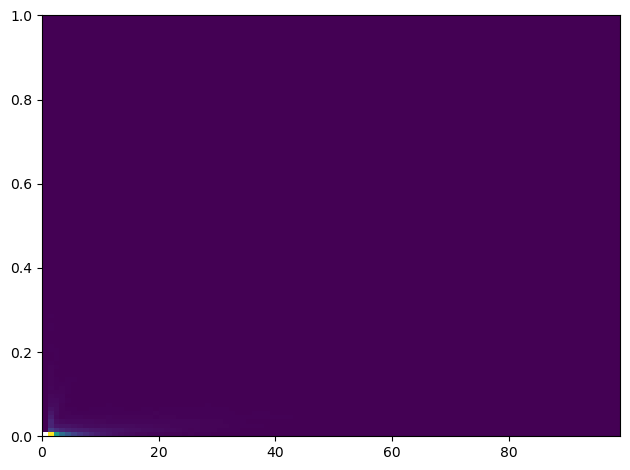

In [77]:
plt.hist2d(firstprogs[:,0], np.ndarray.flatten(percentages(firstprogs)), [np.linspace(0,99,100), np.linspace(0,1,101)], cmax = 10000)
plt.tight_layout()

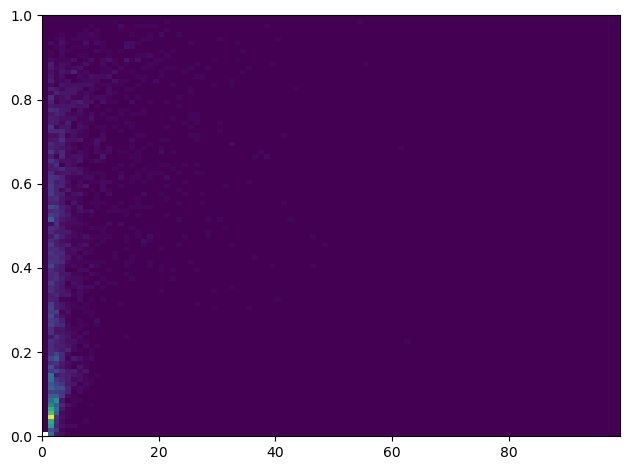

In [80]:
plt.hist2d(nextprogs[:,0], np.ndarray.flatten(percentages(nextprogs)), [np.linspace(0,99,100), np.linspace(0,1,101)], cmax = 250)
plt.tight_layout()
